In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Loading Dataset

In [2]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.mobilenet import MobileNet
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing import image
from glob import glob

In [3]:
IMAGE_SIZE = 64

In [4]:
train_path = '/content/drive/MyDrive/jpeg_shape_classes/train'
test_path =  '/content/drive/MyDrive/jpeg_shape_classes/test'

In [5]:
from PIL import Image
import os
from IPython.display import display
from IPython.display import Image as _Imgdis

folder = train_path + '/oval/0.jpg'

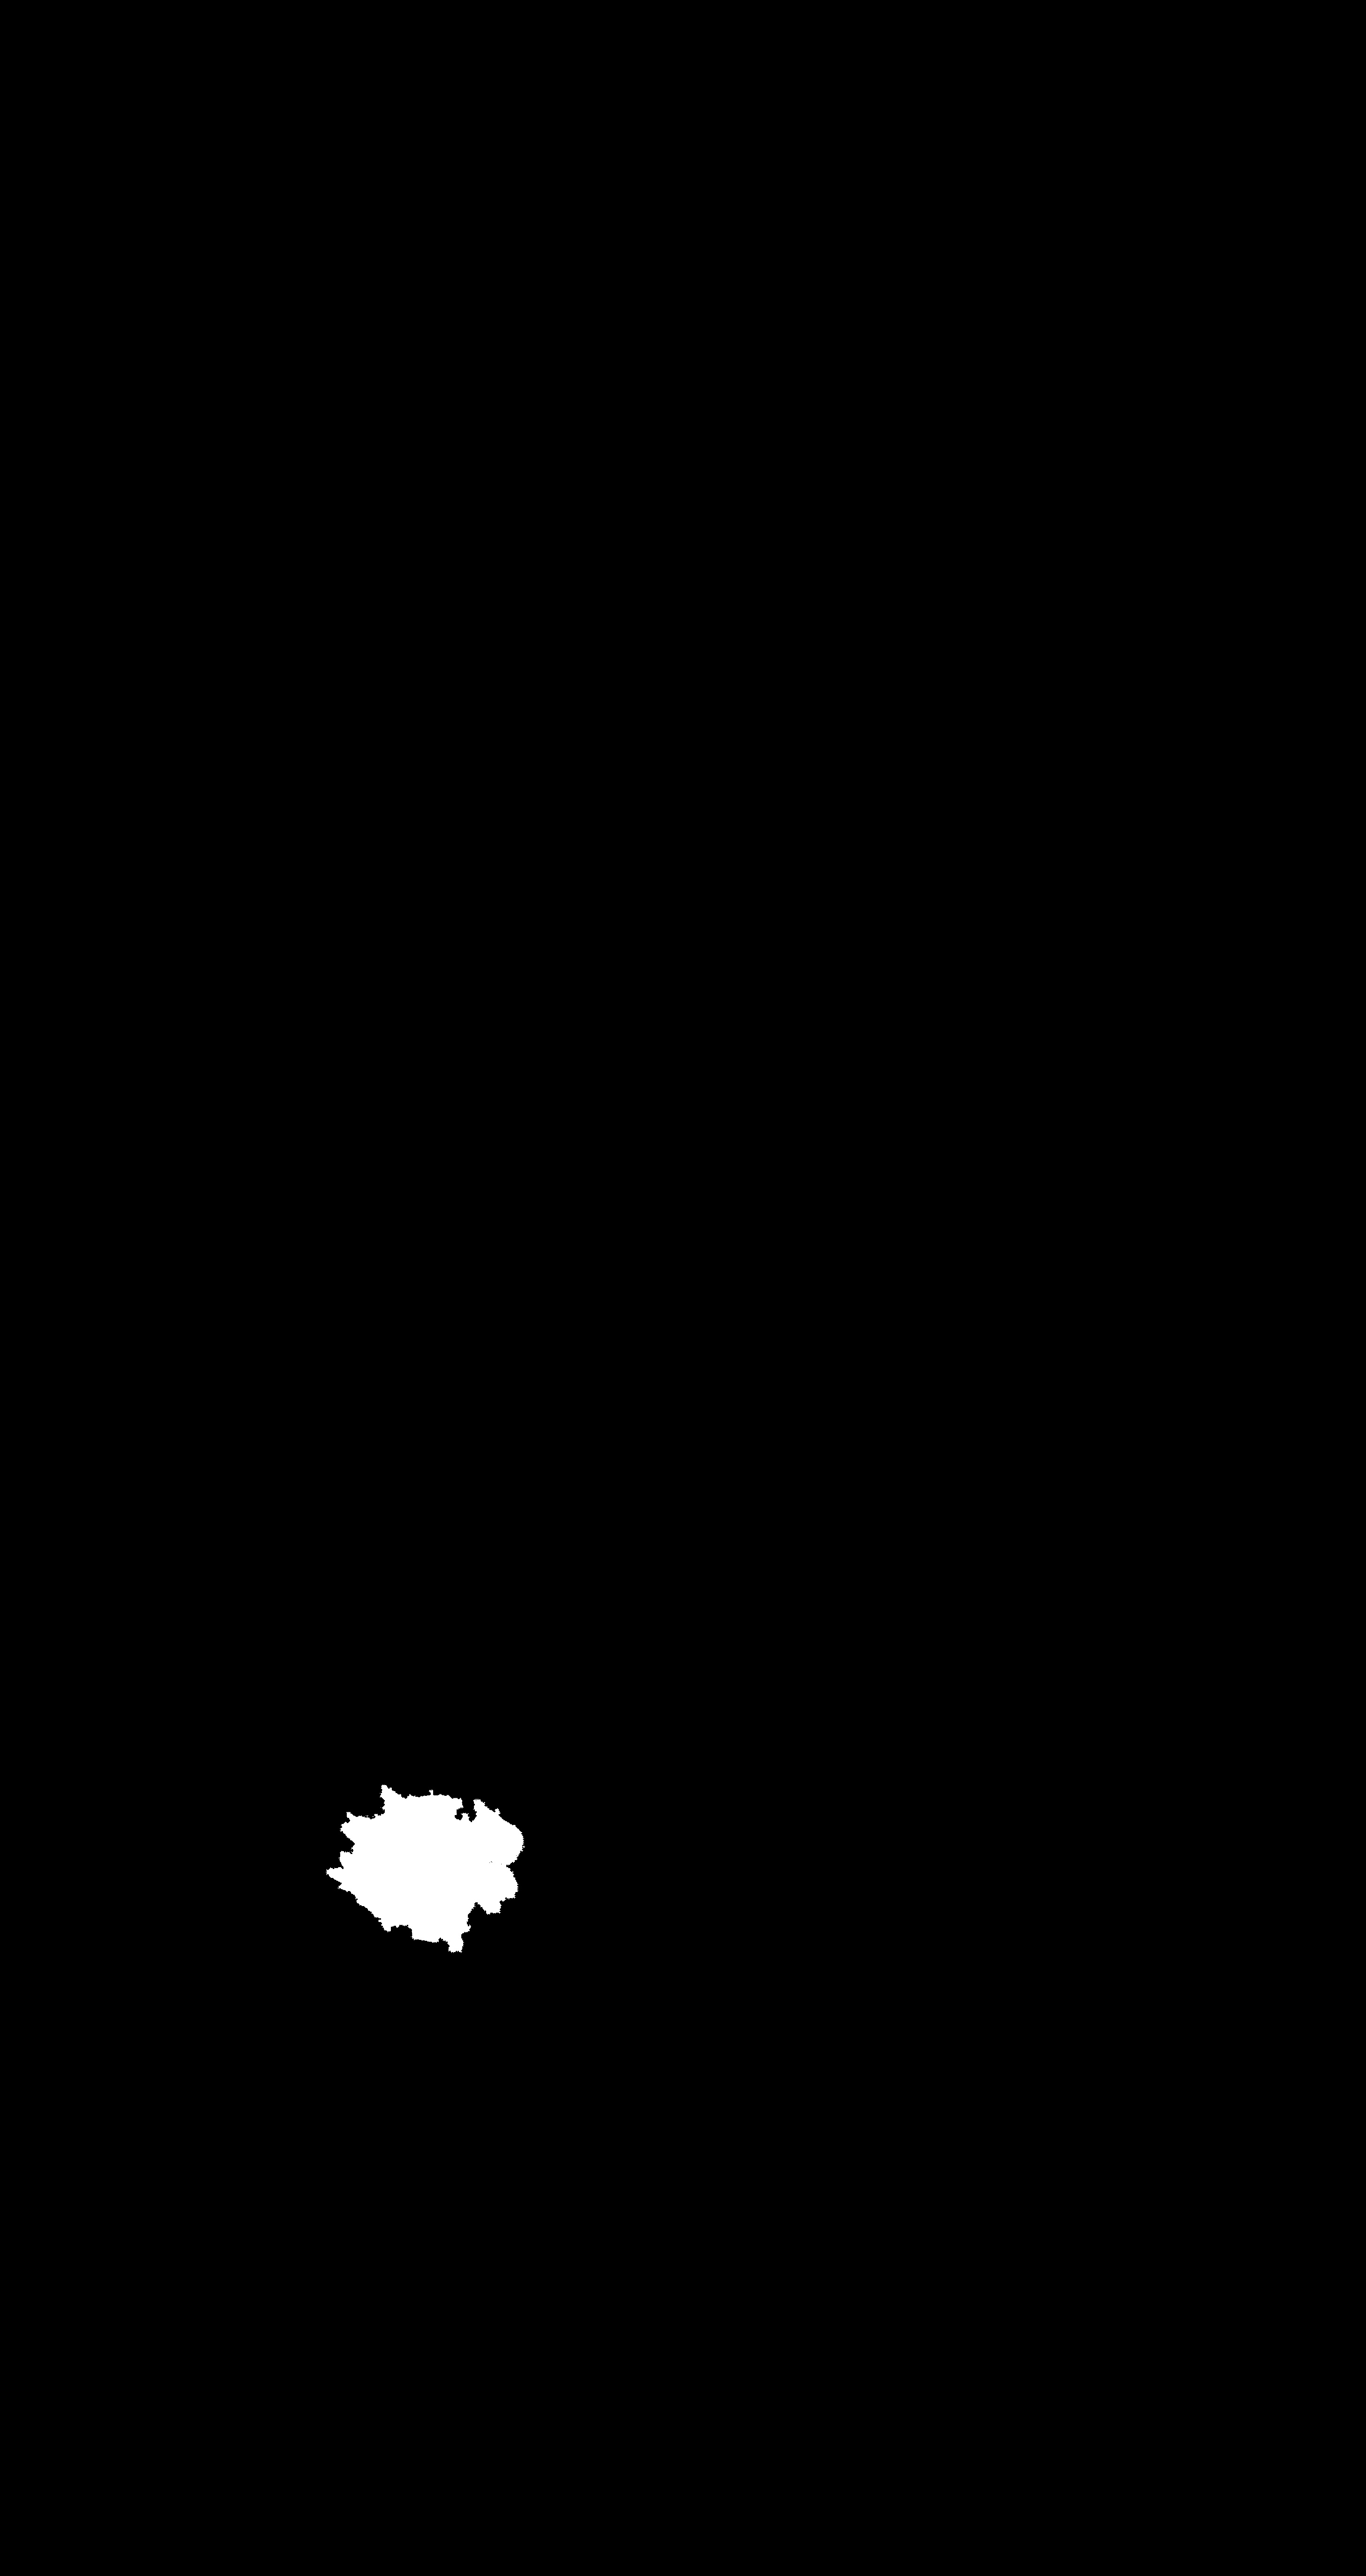

In [6]:
_Imgdis(folder,width=256,height=256)

# Implementing transfer learning

In [7]:
Mobilenet = MobileNet(input_shape= (IMAGE_SIZE, IMAGE_SIZE, 3), weights='imagenet', include_top= False)

17235968/17225924 [==============================] - 1s 0us/step


In [8]:
Mobilenet.input

<KerasTensor: shape=(None, 64, 64, 3) dtype=float32 (created by layer 'input_1')>

In [9]:
for layer in Mobilenet.layers:
    layer.trainable = False

In [10]:
folders = glob('/content/drive/MyDrive/jpeg_shape_classes/train/*')
print(len(folders))

4


In [11]:
x = Flatten()(Mobilenet.output)
prediction = Dense(len(folders), activation= 'softmax')(x)

model = Model(inputs=Mobilenet.input, outputs = prediction)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv1 (Conv2D)              (None, 32, 32, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 32, 32, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 32, 32, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 32, 32, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 32, 32, 32)       128       
 ation)                                                      

In [12]:
import tensorflow as tf 
from keras import optimizers

adam = tf.optimizers.Adam()

model.compile(loss='categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

In [13]:
data_gen = image.ImageDataGenerator(preprocessing_function= preprocess_input)

In [14]:
train_set = data_gen.flow_from_directory(train_path, target_size= (64,64), batch_size = 32, class_mode= 'categorical')
test_set = data_gen.flow_from_directory(test_path, target_size= (64,64), batch_size = 32, class_mode= 'categorical')

Found 1145 images belonging to 4 classes.
Found 331 images belonging to 4 classes.


# Training the model

In [15]:
from datetime import datetime
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/checkpoint/VGG.h5',verbose=2,save_best_only=True)

callbacks = [checkpoint]

In [16]:
history = model.fit(train_set,epochs=50,callbacks=callbacks,validation_data=test_set)

Epoch 1/50
36/36 [==============================] - ETA: 0s - loss: 1.3516 - accuracy: 0.3266 
Epoch 1: val_loss improved from inf to 1.37863, saving model to /content/drive/MyDrive/checkpoint/VGG.h5
36/36 [==============================] - 1175s 33s/step - loss: 1.3516 - accuracy: 0.3266 - val_loss: 1.3786 - val_accuracy: 0.3142
Epoch 2/50
36/36 [==============================] - ETA: 0s - loss: 1.2699 - accuracy: 0.3878
Epoch 2: val_loss did not improve from 1.37863
36/36 [==============================] - 72s 2s/step - loss: 1.2699 - accuracy: 0.3878 - val_loss: 1.3895 - val_accuracy: 0.2991
Epoch 3/50
36/36 [==============================] - ETA: 0s - loss: 1.2254 - accuracy: 0.4341
Epoch 3: val_loss did not improve from 1.37863
36/36 [==============================] - 74s 2s/step - loss: 1.2254 - accuracy: 0.4341 - val_loss: 1.3871 - val_accuracy: 0.3202
Epoch 4/50
36/36 [==============================] - ETA: 0s - loss: 1.2036 - accuracy: 0.4393
Epoch 4: val_loss did not improve 

In [17]:
import matplotlib.pyplot as plt

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('accuracy_mobilenet_pretrain_all_layers.jpg', dpi = 400)
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('loss_mobilenet_pretrain_all_layers.jpg', dpi = 400)

In [19]:
y_test =test_set.labels
y_pred = model.predict(test_set)

In [20]:
import numpy as np

In [21]:
y_pred_proccessed = []
for i in y_pred:
    index_max = np.argmax(i)
    y_pred_proccessed.append(index_max)

y_pred_proccessed = np.array(y_pred_proccessed, dtype= np.float32)

In [22]:
import sklearn.metrics as metrics

In [23]:
matrix = metrics.confusion_matrix(y_test, y_pred_proccessed)

In [25]:
import seaborn as sn
import pandas as pd

In [26]:
df_cm = pd.DataFrame(matrix, index = [i for i in ['round', 'oval', 'lobulated', 'irregular']],
                  columns = [i for i in ['round', 'oval', 'lobulated', 'irregular']])

In [ ]:
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap='BuPu')
plt.savefig('confmatrix_mobilenet_pretrain_all_layers.jpg',dpi=400)